In [22]:
from os import chdir
from typing import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})

In [23]:
#load train set
train = pd.read_csv('dataset/train-balanced.csv', sep='\t', names=['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'])
train.head(2)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,1476662123,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,1477959850,The blazers and Mavericks (The wests 5 and 6 s...


In [24]:
#load test set
test = pd.read_csv('dataset/test-balanced.csv', sep='\t', names=['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'])
test.head(2)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,Actually most of her supporters and sane peopl...,Quinnjester,politics,3,3,0,2016-09,1473569605,Hillary's Surrogotes Told to Blame Media for '...
1,0,They can't survive without an echo chamber whi...,TheGettysburgAddress,The_Donald,13,-1,-1,2016-11,1478788413,Thank God Liberals like to live in concentrate...


In [25]:
#drop rows without comment text
train['comment'] = train['comment'].dropna(axis=0)
test['comment'] = test['comment'].dropna(axis=0)

In [26]:
#cast comments to string
train['comment'] = train['comment'].astype(str)
train['parent_comment'] = train['parent_comment'].astype(str)
test['comment'] = test['comment'].astype(str)
test['parent_comment'] = test['parent_comment'].astype(str)

In [27]:
# classify subreddits (only run once idiot)
comment_series = pd.concat((train["subreddit"], test["subreddit"]))
unique_values = comment_series.unique()
value_dict = dict(enumerate(unique_values))
lookup = {v: k for k, v in value_dict.items()}
train["subreddit"] = train["subreddit"].map(lookup)
test["subreddit"] = test["subreddit"].map(lookup)

In [28]:
#drop author
train = train.drop("author", axis=1)
test = test.drop("author", axis=1)

In [29]:
#reduce dates to year (temporary)
train['date'] = pd.to_datetime(train['date'],yearfirst=True)
train['year'] = train['date'].apply(lambda d: d.year)
test['date'] = pd.to_datetime(test['date'],yearfirst=True)
test['year'] = test['date'].apply(lambda d: d.year)

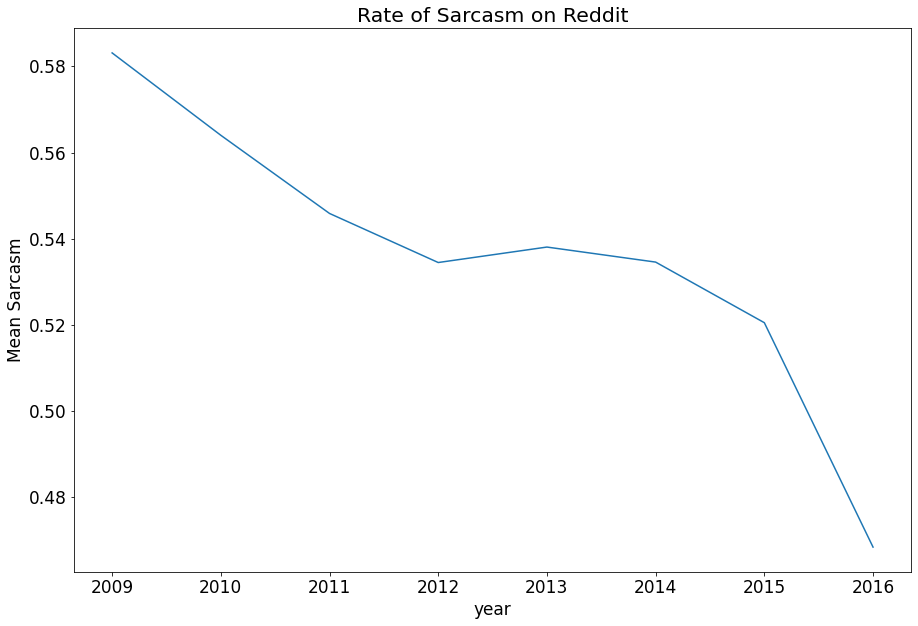

In [30]:
#plt sarcasm hist
comments_by_year = train.groupby('year')['label'].agg([np.sum,np.mean])
fig = plt.figure(figsize=(15,10), facecolor='#ffffff')
comments_by_year['mean'].plot(kind='line')
plt.ylabel('Mean Sarcasm')
plt.title('Rate of Sarcasm on Reddit')
fig.savefig('graphs/sarcasm_timeline.png')

In [31]:
#drop year date date
train = train.drop("year", axis=1)
train = train.drop("date", axis=1)
test = test.drop("year", axis=1)
test = test.drop("date", axis=1)

In [32]:
#saving time as seconds of day (starting midnight)
#might cause problems because of time zone differences
train['time'] = train['created_utc'].map(lambda x: x%86400)
test['time'] = test['created_utc'].map(lambda x: x%86400)

In [33]:
#add day of week column (monday=0, ...,  sunday=6)
train['created_utc'] = pd.to_datetime(train['created_utc'], unit='s')
train['day_of_week'] = train['created_utc'].dt.day_of_week
test['created_utc'] = pd.to_datetime(test['created_utc'], unit='s')
test['day_of_week'] = test['created_utc'].dt.day_of_week

In [34]:
#drop original created_utc column. no longer needed.
train = train.drop("created_utc", axis=1)
test = test.drop("created_utc", axis=1)

In [35]:
#create column with comment text length
train['comment_length'] = train['comment'].str.len()
train['parent_comment_length'] = train['parent_comment'].str.len()
test['comment_length'] = test['comment'].str.len()
test['parent_comment_length'] = test['parent_comment'].str.len()

dropped 55676 comments with >400 chars in training
dropped 13848 comments with >400 chars in testing


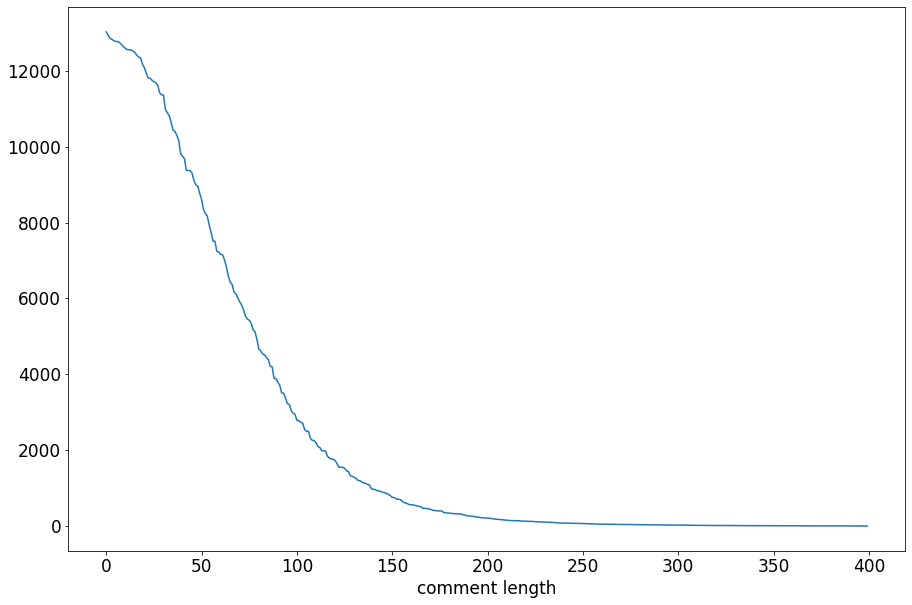

In [36]:
#drop rows with comments > 400 chars
number_comments_before_drop = train.shape[0]
train = train.drop(train[(train.comment_length > 400)].index)
train = train.drop(train[(train.parent_comment_length > 400)].index)
number_comments_after_drop = train.shape[0]
print('dropped', number_comments_before_drop - number_comments_after_drop, 'comments with >400 chars in training')

number_comments_before_drop = test.shape[0]
test = test.drop(test[(test.comment_length > 400)].index)
test = test.drop(test[(test.parent_comment_length > 400)].index)
number_comments_after_drop = test.shape[0]

print('dropped', number_comments_before_drop - number_comments_after_drop, 'comments with >400 chars in testing')

#plot number comments with letter counts
fig = plt.figure(figsize=(15,10), facecolor='#ffffff')
data = train['comment_length'].value_counts().to_numpy()
plt.plot(data)
plt.xlabel('comment length')
fig.savefig('graphs/comment_length.png')

In [37]:
#detect presence of smileys in comment text
def count_smileys(smileys: list, comment: str) -> float:
    count = 0
    for smiley in smileys: count += comment.count(smiley)
    return count/len(comment)
    
smileys = [':P', '\"', 'xD', 'XD', ':D', ':)',':‑)', ':>', '8)', ':o', ':^)', '=)', ':/']
train['smileys'] = train['comment'].map(lambda comment: count_smileys(smileys, comment))
train['smileys_parent'] = train['parent_comment'].map(lambda comment: count_smileys(smileys, comment))
test['smileys'] = test['comment'].map(lambda comment: count_smileys(smileys, comment))
test['smileys_parent'] = test['parent_comment'].map(lambda comment: count_smileys(smileys, comment))

In [38]:
#detect presence of sarcasm indicators in comment text
def count_indiccators(indicators: list, comment: str) -> float:
    count = 0
    for indicator in indicators: count += comment.lower().count(indicator)
    return count/len(comment)
    
indicators = ['...', 'duh', 'lol', 'rofl', 'hehe', 'psh']
train['sarcasm_indicators'] = train['comment'].map(lambda comment: count_indiccators(indicators, comment))
train['sarcasm_indicators_parent'] = train['parent_comment'].map(lambda comment: count_indiccators(indicators, comment))
test['sarcasm_indicators'] = test['comment'].map(lambda comment: count_indiccators(indicators, comment))
test['sarcasm_indicators_parent'] = test['parent_comment'].map(lambda comment: count_indiccators(indicators, comment))

In [39]:
#detect presence of caps lock in comment text
def count_capslock(comment: str) -> float:
    count = 0
    #pad the comment text with whitespaces
    comment_padded = ' ' + comment + ' '
    for pos, char in enumerate(comment):
        #check if previous and current char is upper
        if (comment_padded[pos].isupper() and (comment_padded[pos-1].isupper() or comment_padded[pos+1].isupper())):
            count += 1
    return count/len(comment)

train['caps_lock'] = train['comment'].map(lambda comment: count_capslock(comment))
train['caps_lock_parent'] = train['parent_comment'].map(lambda comment: count_capslock(comment))
test['caps_lock'] = test['comment'].map(lambda comment: count_capslock(comment))
test['caps_lock_parent'] = test['parent_comment'].map(lambda comment: count_capslock(comment))

In [40]:
#detect presence of letter duplication in comment text
def count_letter_dupes(comment: str) -> float:
    count = 0
    #pad the comment text with whitespaces
    comment_padded = ' ' + comment + ' '
    for pos, char in enumerate(comment):
        #check if previous and next char is the same as current
        #counts only of n>2 dupes, counts number letter dupes - 2 
        if ((comment_padded[pos] == comment_padded[pos-1]) and (comment_padded[pos] == comment_padded[pos+1])):
            count += 1
    return count/len(comment)

train['letter_duplication'] = train['comment'].map(lambda comment: count_letter_dupes(comment))
train['letter_duplication_parent'] = train['parent_comment'].map(lambda comment: count_letter_dupes(comment))
test['letter_duplication'] = test['comment'].map(lambda comment: count_letter_dupes(comment))
test['letter_duplication_parent'] = test['parent_comment'].map(lambda comment: count_letter_dupes(comment))

Index(['label', 'comment', 'subreddit', 'score', 'ups', 'downs',
       'parent_comment', 'time', 'day_of_week', 'comment_length',
       'parent_comment_length', 'smileys', 'smileys_parent',
       'sarcasm_indicators', 'sarcasm_indicators_parent', 'caps_lock',
       'caps_lock_parent', 'letter_duplication', 'letter_duplication_parent'],
      dtype='object')


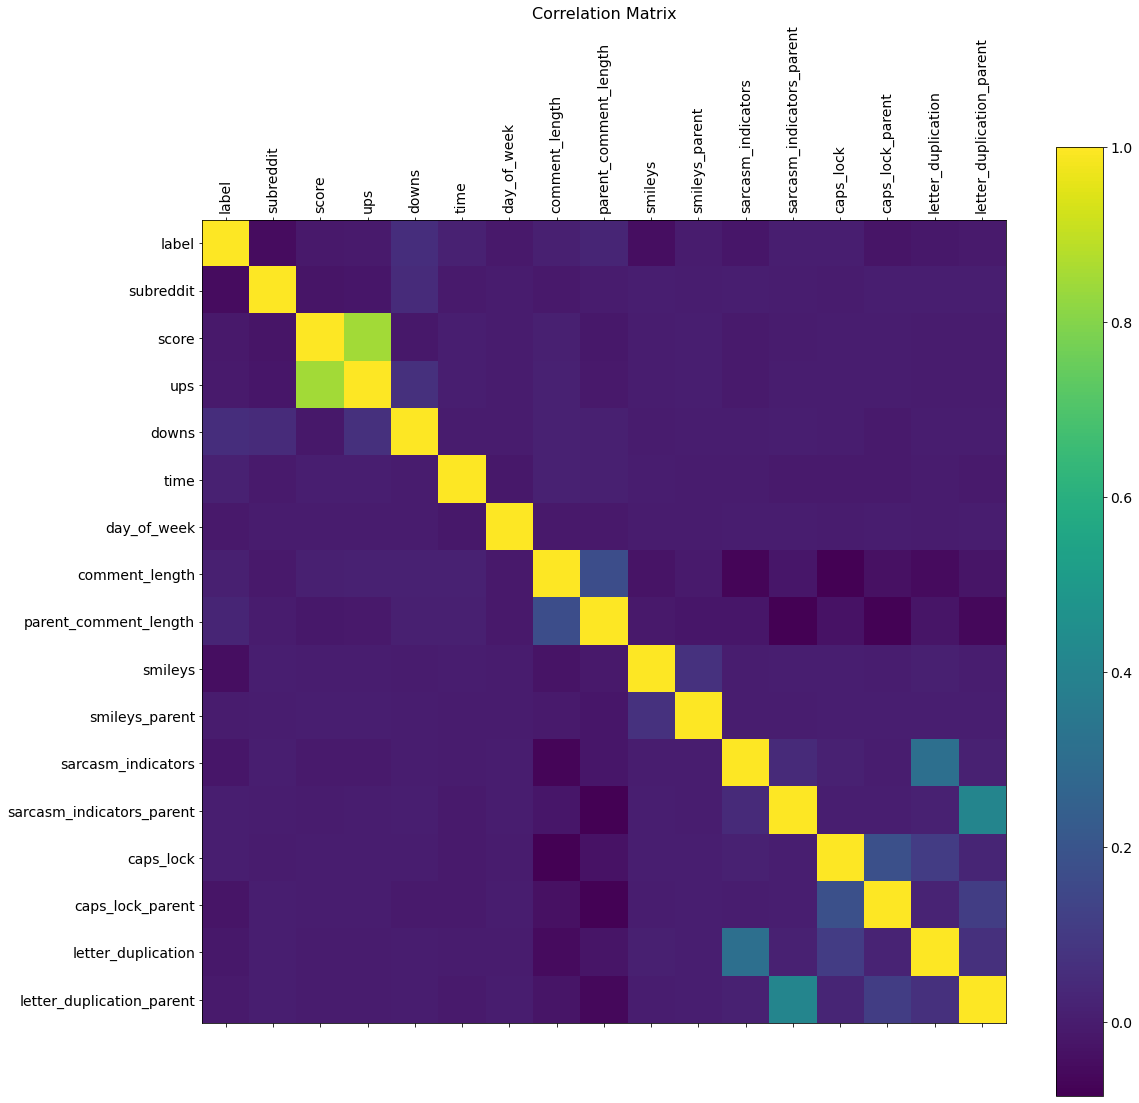

In [41]:
print(train.columns)
#comment and parent_comment not shown

fig = plt.figure(figsize=(18, 17), facecolor='#ffffff')
plt.matshow(train.corr(), fignum=fig.number)
plt.xticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
fig.savefig('graphs/correlation_matrix.png')

In [42]:
train.head(2)

,label,comment,subreddit,score,ups,downs,parent_comment,time,day_of_week,comment_length,parent_comment_length,smileys,smileys_parent,sarcasm_indicators,sarcasm_indicators_parent,caps_lock,caps_lock_parent,letter_duplication,letter_duplication_parent
0,0,NC and NH.,0,2,-1,-1,"Yeah, I get that argument. At this point, I'd ...",86123,6,10,80,0.0,0.0,0.0,0.0,0.4,0.025,0.0,0.0
1,0,You do know west teams play against west teams...,1,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 s...,1450,1,74,134,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0


In [43]:
# save dataset for machine_leaning.ipynb to use
train.to_csv(path_or_buf='dataset/final_train.csv', sep='\t', index=False)
test.to_csv(path_or_buf='dataset/final_test.csv', sep='\t', index=False)